In [1]:
import tensorflow as tf
from tensorflow import keras as keras
print(tf.__version__)

print(keras.__version__)

2.3.1
2.4.0


# Zad
Pobierz dane

In [2]:
from sklearn.datasets import fetch_20newsgroups
newsgroups = fetch_20newsgroups(subset='train',categories=['sci.crypt', 'sci.electronics'])

Wypisz pierwszy tekst

In [3]:
# newsgroups_train.data[0]
print(newsgroups.data[0])

From: tedwards@eng.umd.edu (Thomas Grant Edwards)
Subject: Re: Once tapped, your code is no good any more.
Organization: Project GLUE, University of Maryland, College Park
Lines: 25
Distribution: na
NNTP-Posting-Host: pipa.src.umd.edu

In article <1r1r3nINNebn@dns1.NMSU.Edu> amolitor@nmsu.edu (Andrew Molitor) writes:
>In article <C5so84.Hxv@demon.co.uk> Graham Toal <gtoal@gtoal.com> writes:
>>Actually, I am *completely* baffled by why Dorothy Denning has chosen
>>to throw away her academic respectability like this.

>	Actually, I've been following her remarks for some time, with
>interest. I'm also a member of academia, and her remarks have nothing
>but elevate her respectability in my eyes. It remains to be seen whether
>you are the radical fringe, or I.

>	It is generally an error to assume that your beliefs are held by
>the majority, or even a sizable minority. Especially when you're seeing
>tens, nay dozens, of people on usenet agreeing with you.

The people on usenet are clearly a

In [4]:
print(len(newsgroups.data))

1186


In [5]:
X = newsgroups.data
y = newsgroups.target

len(X)

1186

# Zad
Zbuduj labele $y$ jako **One-hot encoding**:

In [9]:
# from tensorflow.keras.utils import np_utils
from tensorflow.python.keras.utils import np_utils
y = np_utils.to_categorical(y)
y[:10]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [10]:
import nltk
import string
import re
import pandas as pd

In [11]:
def extract_content(mail):    
    # wyciagniecie tresci maila   
    return mail[mail.find("\n\n"):]

def extract_subject(mail):
    return re.findall(r'Subject:(.+)',mail)[0]


def stem_helper(word,stemmer):
    try:
        y = stemmer.stem(word)
    except:
        y = word
    return y



def clean_text(x, stemmer = nltk.PorterStemmer()):   
    """
    x - jeden mail
    """    
 
    #tokenizacja - rozbicie na liste tokenow
    x_t = nltk.word_tokenize(x)    
    # usuwanie znakow interpunkcyjnych
    translator = str.maketrans('', '', string.punctuation)
    x_t = [word.translate(translator) for word in x_t]    
    # zamina liter male
    x_t = [word.lower() for word in x_t]    
    # usuwanie zbednych tokenow
    x_t = [w for w in x_t if w not in nltk.corpus.stopwords.words("english")+["nt"]]    
    # stemming
    x_t = [stem_helper(word,stemmer) for word in x_t]    
    # sklejenie do napisu
    x_new = ' '.join(x_t)    
    return x_new


X_c = [clean_text(extract_content(x)) for x in X]
X_s = [clean_text(extract_subject(x)) for x in X]

X = pd.DataFrame({"subject":X_s, "content":X_c})

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_c,y,test_size=400)
#bierzemy tylko tresc - bez tytulu
print(y_test.shape)

(400, 2)


In [13]:
from sklearn.feature_extraction.text import CountVectorizer
cv =CountVectorizer(max_features=2000)

cv.fit(X_train,y_train)

X_train_transformed = cv.transform(X_train).todense()
X_test_transformed = cv.transform(X_test).todense()

In [14]:
X_test_transformed.shape, y_test.shape

((400, 2000), (400, 2))

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.callbacks import History
from tensorflow.keras.regularizers import l2

history = History()
model = Sequential()
model.add(Dense(100,activation="relu",input_shape=(X_train_transformed.shape[1],), kernel_regularizer=l2(0.1)))
model.add(Dropout(0.5))
model.add(Dense(2,activation="softmax"))
Adam = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss="categorical_crossentropy",optimizer=Adam, metrics=["categorical_accuracy"])


early_stopping = EarlyStopping(patience=3)
save_best_model = ModelCheckpoint("wagi_20news_dense",save_best_only=True)

model.fit(X_train_transformed,y_train, batch_size=32, validation_split=0.3, epochs=100, callbacks=[early_stopping, save_best_model, history])


# model.load_weights("wagi_20news_dense.h5py")
# model.evaluate(X_test_transformed, y_test)

Epoch 1/100
18/18 [==============================] - 1s 42ms/step - loss: 19.0934 - categorical_accuracy: 0.4855 - val_loss: 18.0966 - val_categorical_accuracy: 0.5720
Epoch 2/100
18/18 [==============================] - 1s 43ms/step - loss: 17.4452 - categorical_accuracy: 0.5364 - val_loss: 16.5681 - val_categorical_accuracy: 0.6356
Epoch 3/100
18/18 [==============================] - 1s 38ms/step - loss: 15.9645 - categorical_accuracy: 0.6164 - val_loss: 15.1649 - val_categorical_accuracy: 0.6610
Epoch 4/100
18/18 [==============================] - 1s 35ms/step - loss: 14.6048 - categorical_accuracy: 0.6200 - val_loss: 13.8788 - val_categorical_accuracy: 0.6992
Epoch 5/100
18/18 [==============================] - 1s 37ms/step - loss: 13.3883 - categorical_accuracy: 0.6909 - val_loss: 12.6969 - val_categorical_accuracy: 0.7331
Epoch 6/100
18/18 [==============================] - 1s 37ms/step - loss: 12.2134 - categorical_accuracy: 0.7418 - val_loss: 11.6106 - val_categorical_accuracy:

18/18 [==============================] - 1s 39ms/step - loss: 1.9256 - categorical_accuracy: 0.9691 - val_loss: 1.8652 - val_categorical_accuracy: 0.9492
Epoch 27/100
18/18 [==============================] - 1s 40ms/step - loss: 1.7676 - categorical_accuracy: 0.9745 - val_loss: 1.7125 - val_categorical_accuracy: 0.9449
Epoch 28/100
18/18 [==============================] - 1s 38ms/step - loss: 1.6121 - categorical_accuracy: 0.9818 - val_loss: 1.5732 - val_categorical_accuracy: 0.9492
Epoch 29/100
18/18 [==============================] - 1s 38ms/step - loss: 1.4796 - categorical_accuracy: 0.9709 - val_loss: 1.4476 - val_categorical_accuracy: 0.9449
Epoch 30/100
18/18 [==============================] - 1s 42ms/step - loss: 1.3626 - categorical_accuracy: 0.9691 - val_loss: 1.3342 - val_categorical_accuracy: 0.9449
Epoch 31/100
18/18 [==============================] - 1s 40ms/step - loss: 1.2446 - categorical_accuracy: 0.9709 - val_loss: 1.2324 - val_categorical_accuracy: 0.9449
Epoch 32/10

18/18 [==============================] - 1s 41ms/step - loss: 0.3794 - categorical_accuracy: 0.9800 - val_loss: 0.4203 - val_categorical_accuracy: 0.9534
Epoch 53/100
18/18 [==============================] - 1s 38ms/step - loss: 0.3717 - categorical_accuracy: 0.9891 - val_loss: 0.4107 - val_categorical_accuracy: 0.9534
Epoch 54/100
18/18 [==============================] - 1s 46ms/step - loss: 0.3591 - categorical_accuracy: 0.9818 - val_loss: 0.4003 - val_categorical_accuracy: 0.9576
Epoch 55/100
18/18 [==============================] - 1s 42ms/step - loss: 0.3467 - categorical_accuracy: 0.9818 - val_loss: 0.3903 - val_categorical_accuracy: 0.9534
Epoch 56/100
18/18 [==============================] - 1s 42ms/step - loss: 0.3381 - categorical_accuracy: 0.9873 - val_loss: 0.3826 - val_categorical_accuracy: 0.9534
Epoch 57/100
18/18 [==============================] - 1s 39ms/step - loss: 0.3313 - categorical_accuracy: 0.9873 - val_loss: 0.3760 - val_categorical_accuracy: 0.9576
Epoch 58/10

18/18 [==============================] - 0s 3ms/step - loss: 0.2452 - categorical_accuracy: 0.9855 - val_loss: 0.3254 - val_categorical_accuracy: 0.9492
Epoch 79/100
18/18 [==============================] - 0s 4ms/step - loss: 0.2483 - categorical_accuracy: 0.9836 - val_loss: 0.3249 - val_categorical_accuracy: 0.9492


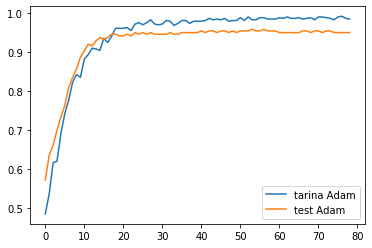

In [19]:
import matplotlib.pyplot as plt
plt.plot(history.history['categorical_accuracy'], label = "tarina Adam")
plt.plot(history.history['val_categorical_accuracy'], label = "test Adam")

plt.legend()
plt.show()

# Zad.

Naucz jak najlepszy model na tym zbiorze danych.